# Generating touch data in time: RoboJam

- Let's look at some "touch screen music" data.
- E.g., music made with the "MicroJam" app:

![MicroJam Performance](https://media.giphy.com/media/XWIkHvErZtPG0/giphy.gif)

These performances are sequences of x and y locations, as well as time!

In MicroJam, you can "reply" to performances made by other users; but what if you don't have any friends??? (Too much time spent on Neural Networks). 

Let's make "RoboJam", a system to respond automatically to performances.

- We need to predict x and y values---as well as time!
- So, we use a 3 dimensional MDN-RNN.

The idea is to generate "responses" to an existing touchscreen sequence. Here's some examples of what it will do:

![Robojam Model Examples](https://preview.ibb.co/mpfa9T/robojam_examples.jpg)

In [3]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Input
import numpy as np
import tensorflow as tf
import math
import h5py
import random
import time
import pandas as pd
from context import * # imports MDN
%matplotlib widget
import matplotlib.pyplot as plt


input_colour = 'darkblue'
gen_colour = 'firebrick'

In [4]:
# Only for GPU use:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


## First, download the dataset

- This is a set of microjam performances collected from our lab

In [5]:
# Download microjam performance data if needed.
import urllib.request
url = 'https://github.com/cpmpercussion/creative-prediction-datasets/raw/main/datasets/TinyPerformanceCorpus.h5'
urllib.request.urlretrieve(url, './TinyPerformanceCorpus.h5')  

('./TinyPerformanceCorpus.h5', <http.client.HTTPMessage at 0x7f160630fc90>)

## Helper functions for touchscreen performances

We need a few helper functions for managing performances:
    
- Convert performances to and from pandas dataframes.
- Generate random touches.
- Sample whole performances from scratch and from a priming performance.
- Plot performances including dividing into swipes.

In [6]:
SCALE_FACTOR = 1

def perf_df_to_array(perf_df, include_moving=False):
    """Converts a dataframe of a performance into array a,b,dt format."""
    perf_df['dt'] = perf_df.time.diff()
    perf_df.dt = perf_df.dt.fillna(0.0)
    # Clean performance data
    # Tiny Performance bounds defined to be in [[0,1],[0,1]], edit to fix this.
    perf_df.at[perf_df[perf_df.dt > 5].index, 'dt'] = 5.0
    perf_df.at[perf_df[perf_df.dt < 0].index, 'dt'] = 0.0
    perf_df.at[perf_df[perf_df.x > 1].index, 'x'] = 1.0
    perf_df.at[perf_df[perf_df.x < 0].index, 'x'] = 0.0
    perf_df.at[perf_df[perf_df.y > 1].index, 'y'] = 1.0
    perf_df.at[perf_df[perf_df.y < 0].index, 'y'] = 0.0
    if include_moving:
        output = np.array(perf_df[['x', 'y', 'dt', 'moving']])
    else:
        output = np.array(perf_df[['x', 'y', 'dt']])
    return output


def perf_array_to_df(perf_array):
    """Converts an array of a performance (a,b,dt(,moving) format) into a dataframe."""
    perf_array = perf_array.T
    perf_df = pd.DataFrame({'x': perf_array[0], 'y': perf_array[1], 'dt': perf_array[2]})
    if len(perf_array) == 4:
        perf_df['moving'] = perf_array[3]
    else:
        # As a rule of thumb, could classify taps with dt>0.1 as taps, dt<0.1 as moving touches.
        perf_df['moving'] = 1
        perf_df.at[perf_df[perf_df.dt > 0.1].index, 'moving'] = 0
    perf_df['time'] = perf_df.dt.cumsum()
    perf_df['z'] = 38.0
    perf_df = perf_df.set_index(['time'])
    return perf_df[['x', 'y', 'z', 'moving']]


def random_touch(with_moving=False):
    """Generate a random tiny performance touch."""
    if with_moving:
        return np.array([np.random.rand(), np.random.rand(), 0.01, 0])
    else:
        return np.array([np.random.rand(), np.random.rand(), 0.01])


def constrain_touch(touch, with_moving=False):
    """Constrain touch values from the MDRNN"""
    touch[0] = min(max(touch[0], 0.0), 1.0)  # x in [0,1]
    touch[1] = min(max(touch[1], 0.0), 1.0)  # y in [0,1]
    touch[2] = max(touch[2], 0.001)  # dt # define minimum time step
    if with_moving:
        touch[3] = np.greater(touch[3], 0.5) * 1.0
    return touch


def generate_random_tiny_performance(model, n_mixtures, first_touch, time_limit=5.0, steps_limit=1000, temp=1.0, sigma_temp=0.0, predict_moving=False):
    """Generates a tiny performance up to 5 seconds in length."""
    if predict_moving:
        out_dim = 4
    else:
        out_dim = 3
    time = 0
    steps = 0
    previous_touch = first_touch
    performance = [previous_touch.reshape((out_dim,))]
    while (steps < steps_limit and time < time_limit):
        params = model.predict(previous_touch.reshape(1,1,out_dim) * SCALE_FACTOR)
        previous_touch = mdn.sample_from_output(params[0], out_dim, n_mixtures, temp=temp, sigma_temp=sigma_temp) / SCALE_FACTOR
        output_touch = previous_touch.reshape(out_dim,)
        output_touch = constrain_touch(output_touch, with_moving=predict_moving)
        performance.append(output_touch.reshape((out_dim,)))
        steps += 1
        time += output_touch[2]
    return np.array(performance)


def condition_and_generate(model, perf, n_mixtures, time_limit=5.0, steps_limit=1000, temp=1.0, sigma_temp=0.0, predict_moving=False):
    """Conditions the network on an existing tiny performance, then generates a new one."""
    if predict_moving:
        out_dim = 4
    else:
        out_dim = 3
    time = 0
    steps = 0
    # condition
    for touch in perf:
        params = model.predict(touch.reshape(1, 1, out_dim) * SCALE_FACTOR)
        previous_touch = mdn.sample_from_output(params[0], out_dim, n_mixtures, temp=temp, sigma_temp=sigma_temp) / SCALE_FACTOR
        output = [previous_touch.reshape((out_dim,))]
    # generate
    while (steps < steps_limit and time < time_limit):
        params = model.predict(previous_touch.reshape(1, 1, out_dim) * SCALE_FACTOR)
        previous_touch = mdn.sample_from_output(params[0], out_dim, n_mixtures, temp=temp, sigma_temp=sigma_temp) / SCALE_FACTOR
        output_touch = previous_touch.reshape(out_dim,)
        output_touch = constrain_touch(output_touch, with_moving=predict_moving)
        output.append(output_touch.reshape((out_dim,)))
        steps += 1
        time += output_touch[2]
    net_output = np.array(output)
    return net_output


def divide_performance_into_swipes(perf_df):
    """Divides a performance into a sequence of swipe dataframes for plotting."""
    touch_starts = perf_df[perf_df.moving == 0].index
    performance_swipes = []
    remainder = perf_df
    for att in touch_starts:
        swipe = remainder.iloc[remainder.index < att]
        performance_swipes.append(swipe)
        remainder = remainder.iloc[remainder.index >= att]
    performance_swipes.append(remainder)
    return performance_swipes


input_colour = "#4388ff"
gen_colour = "#ec0205"

def plot_perf_on_ax(perf_df, ax, color="#ec0205", linewidth=3, alpha=0.5):
    """Plot a 2D representation of a performance 2D"""
    swipes = divide_performance_into_swipes(perf_df)
    for swipe in swipes:
        p = ax.plot(swipe.x, swipe.y, 'o-', alpha=alpha, markersize=linewidth)
        plt.setp(p, color=color, linewidth=linewidth)
    ax.set_ylim([1.0,0])
    ax.set_xlim([0,1.0])
    ax.set_xticks([])
    ax.set_yticks([])

def plot_2D(perf_df, name="foo", saving=False, figsize=(5, 5)):
    """Plot a 2D representation of a performance 2D"""
    fig, ax = plt.subplots(figsize=(figsize))
    plot_perf_on_ax(perf_df, ax, color=gen_colour, linewidth=5, alpha=0.7)
    if saving:
        fig.savefig(name+".png", bbox_inches='tight')

def plot_double_2d(perf1, perf2, name="foo", saving=False, figsize=(8, 8)):
    """Plot two performances in 2D"""
    fig, ax = plt.subplots(figsize=(figsize))
    plot_perf_on_ax(perf1, ax, color=input_colour, linewidth=5, alpha=0.7)
    plot_perf_on_ax(perf2, ax, color=gen_colour, linewidth=5, alpha=0.7)
    if saving:
        fig.savefig(name+".png", bbox_inches='tight')
        
# fig, ax = plt.subplots(figsize=(5, 5))
# plot_perf_on_ax(perf_array_to_df(p), ax, color="#ec0205", linewidth=4, alpha=0.7)
# fig.show()

# Load up the Dataset:

The dataset consists of around 1000 5-second performances from the MicroJam app.

This is in a sequence of points consisting of an x-location, a y-location, and a time-delta from the previous point.

When the user swipes, the time-delta is very small, if they tap it's quite large.

Let's have a look at some of the data:

In [8]:
# Load Data
microjam_data_file_name = "./TinyPerformanceCorpus.h5"

with h5py.File(microjam_data_file_name, 'r') as data_file:
    microjam_corpus = data_file['total_performances'][:]

#print("Corpus data points between 100 and 120:") printing not working 
#print(perf_array_to_df(microjam_corpus[100:120]))

print("Some statistics about the dataset:")
pd.DataFrame(microjam_corpus).describe()

Some statistics about the dataset:


,0,1,2
count,172261.000000,172261.000000,172261.000000
mean,0.510843,0.503569,0.036660
std,0.261675,0.256955,0.157370
min,0.000000,0.000000,0.000000
25%,0.289000,0.285000,0.016125
50%,0.518000,0.500000,0.016879
75%,0.732000,0.719251,0.017607
max,1.000000,1.000000,5.000000


- This time, the X and Y locations are *not* differences, but the exact value, but the time is a delta value.
- The data doesn't have a "pen up" value, but we can just call taps with dt>0.1 as taps, dt<0.1 as moving touches.

In [9]:
# Plot a bit of the data to have a look:
plot_2D(perf_array_to_df(microjam_corpus[100:200]))

InvalidIndexError: You can only assign a scalar value not a <class 'int'>

## MDN RNN

- Now we're going to build an MDN-RNN to predict MicroJam data.
- The architecture will be:
    - 3 inputs (x, y, dt)
    - 2 layers of 256 LSTM cells each
    - MDN Layer with 3 dimensions and 5 mixtures.
    - Training model will have a sequence length of 30 (prediction model: 1 in, 1 out)
    
![RoboJam MDN RNN Model](https://preview.ibb.co/cKZk9T/robojam_mdn_diagram.png)
    
- Here's the model parameters and training data preparation. 
- We end up with 172K training examples.

In [13]:
# Training Hyperparameters:
SEQ_LEN = 30
BATCH_SIZE = 256
HIDDEN_UNITS = 128 # Reduced from 256 to 128 for testing
EPOCHS = 8 # reduced from 100 to 8 for testing
VAL_SPLIT=0.15

# Set random seed for reproducibility
SEED = 2345  
random.seed(SEED)
np.random.seed(SEED)

def slice_sequence_examples(sequence, num_steps):
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    return xs

def seq_to_singleton_format(examples):
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[-1])
    return (xs,ys)

sequences = slice_sequence_examples(microjam_corpus, SEQ_LEN+1)
print("Total training examples:", len(sequences))
X, y = seq_to_singleton_format(sequences)
X = np.array(X)
y = np.array(y)
print("X:", X.shape, "y:", y.shape)

Total training examples: 172229
X: (172229, 30, 3) y: (172229, 3)


Now let's set up the model:

In [14]:
OUTPUT_DIMENSION = 3
NUMBER_MIXTURES = 5

model = keras.Sequential()
model.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(None,SEQ_LEN,OUTPUT_DIMENSION), return_sequences=True))
model.add(keras.layers.LSTM(HIDDEN_UNITS))
model.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer=keras.optimizers.Adam())
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 128)           67584     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 mdn_1 (MDN)                 (None, 35)                4515      
                                                                 
Total params: 203683 (795.64 KB)
Trainable params: 203683 (795.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

- Now we do the training
    - batch size of 256
    - 100 epochs.
- This takes about 110s per epoch on Google Colab (3 hours to train)

Here's the training and validation loss from my training run:

![Training and validation loss](figures/robojam-mdn-loss.png)

- The validation loss (in green) tends to jump around a lot in the early epochs.
- The training loss (in blue) has one strange jump around epoch 15, but then reduces quickly at about epoch 20.
- Seems to still be learning, could probably improve this model further.

Epoch 1/8
572/572 [==============================] - ETA: 0s - loss: -1.8479
Epoch 1: val_loss improved from inf to -2.33430, saving model to robojam_mdrnn-E01-VL-2.33.h5
572/572 [==============================] - 80s 134ms/step - loss: -1.8479 - val_loss: -2.3343
Epoch 2/8
572/572 [==============================] - ETA: 0s - loss: -2.9766
Epoch 2: val_loss improved from -2.33430 to -3.21976, saving model to robojam_mdrnn-E02-VL-3.22.h5
572/572 [==============================] - 77s 134ms/step - loss: -2.9766 - val_loss: -3.2198
Epoch 3/8
572/572 [==============================] - ETA: 0s - loss: -2.9733
Epoch 3: val_loss improved from -3.21976 to -3.40379, saving model to robojam_mdrnn-E03-VL-3.40.h5
572/572 [==============================] - 79s 138ms/step - loss: -2.9733 - val_loss: -3.4038
Epoch 4/8
572/572 [==============================] - ETA: 0s - loss: -3.5362
Epoch 4: val_loss improved from -3.40379 to -5.60341, saving model to robojam_mdrnn-E04-VL-5.60.h5
572/572 [==========

/home/ninjatimtam/.cache/pypoetry/virtualenvs/keras-mdn-layer-Fodlja9D-py3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


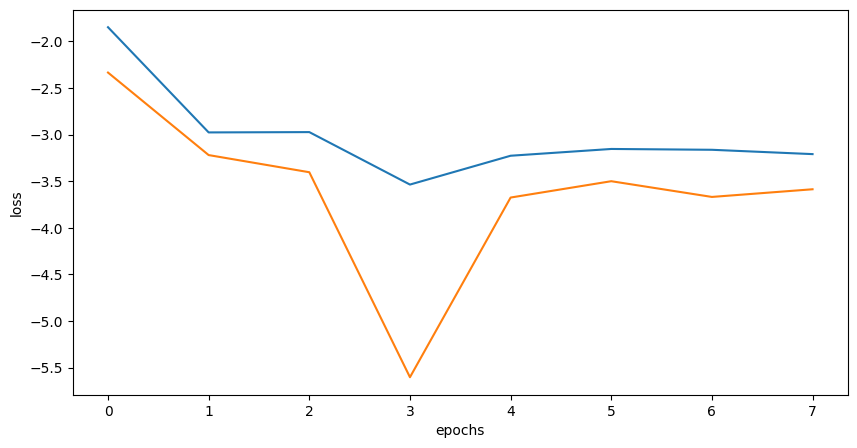

In [15]:
# Train the model

# Define callbacks
filepath="robojam_mdrnn-E{epoch:02d}-VL{val_loss:.2f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True, verbose=1, save_best_only=True, mode='min')
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
callbacks = [keras.callbacks.TerminateOnNaN(), checkpoint, early_stopping]

history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks, validation_split=VAL_SPLIT)

# Save the Model
model.save('robojam-mdrnn.h5')  # creates a HDF5 file of the model

# Plot the loss
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Try out the model

- Let's try out the model
- First we will load up a decoding model with a sequence length of 1.
- The weights are loaded from a the trained model file.

In [16]:
# Decoding Model
decoder = keras.Sequential()
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(1,1,OUTPUT_DIMENSION), return_sequences=True, stateful=True))
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, stateful=True))
decoder.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))
decoder.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer=keras.optimizers.Adam())
decoder.summary()

# decoder.set_weights(model.get_weights())
decoder.load_weights("robojam-mdrnn.h5")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (1, 1, 128)               67584     
                                                                 
 lstm_5 (LSTM)               (1, 128)                  131584    
                                                                 
 mdn_2 (MDN)                 (1, 35)                   4515      
                                                                 
Total params: 203683 (795.64 KB)
Trainable params: 203683 (795.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Plotting some conditioned performances.

This model seems to work best with a very low temperature for sampling from the Gaussian elements (`sigma_temp=0.05`) and a temperature for choosing between mixtures (pi-temperature) of around 1.0.

In [17]:
length = 100
t = random.randint(0,len(microjam_corpus)-length)
ex =  microjam_corpus[t:t+length]  #sequences[600]

decoder.reset_states()
p = condition_and_generate(decoder, ex, NUMBER_MIXTURES, temp=1.5, sigma_temp=0.05)
plot_double_2d(perf_array_to_df(ex), perf_array_to_df(p), figsize=(4,4))

1/1 [==============================] - 0s 18ms/step


InvalidIndexError: You can only assign a scalar value not a <class 'int'>

We can also generate unconditioned performances from a random starting point.

In [ ]:
decoder.reset_states()
t = random_touch()
p = generate_random_tiny_performance(decoder, NUMBER_MIXTURES, t, temp=1.2, sigma_temp=0.01)
plot_2D(perf_array_to_df(p), figsize=(4,4))

# RoboJam in Practice!

- RoboJam is designed for use in a mobile music called MicroJam!
- Check it out on the iTunes App Store (only Apple devices! Soz!)
- [microjam website: https://microjam.info](https://microjam.info)

![RoboJam in action](https://preview.ibb.co/hXg43o/robojam_action_diagram.jpg)